In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

In [192]:
tcga_info = pd.read_csv('../data/paper/clinical_PANCAN_patient_with_followup.tsv', 
                        sep='\t', header=0, index_col=1, dtype=object)

In [24]:
prs = pd.read_csv('~/DATA1/Hyoeun/spliceQTL/Analysis/04_PRS_Diff/runPRSice/INPUT/whole_sample/PRAD/whole-GWAS.SUM.all.score.tab', 
                  sep='\t', header=0, index_col=0)
prs.columns = list(prs.columns[1:]) + ['None']
prs = prs.drop('None', axis=1)

In [193]:
stem = pd.read_csv('../data/TCGA-TARGET-GTEx/mRNA_StemScore.extended.tsv', sep='\t', header=0, index_col=0)

In [194]:
stem = stem[stem['cohort'] == 'TCGA']
stem['patient_id'] = stem.index.str.rsplit('-', 1).str[0]

In [195]:
idx = np.intersect1d(tcga_info.index, prs.index)
onset = pd.to_numeric(tcga_info.loc[idx, 'age_at_initial_pathologic_diagnosis'])

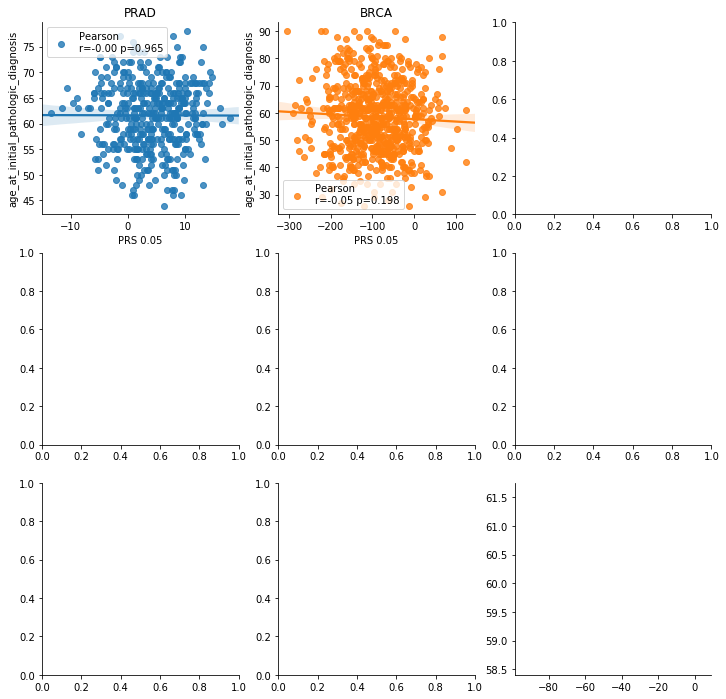

In [191]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
disease_list = ['PRAD', 'BRCA', 'LIHC', 'UCEC', 'THCA', 'LUAD', 'COAD', 'ESCA', 'STAD']
for i in range(len(disease_list)):
    disease = disease_list[i]
    prs = pd.read_csv('/home/omics/DATA1/Hyoeun/spliceQTL/Analysis/04_PRS_Diff/runPRSice/INPUT/whole_sample/Tumor/{0}/whole-GWAS.SUM.all.score.tab'.format(disease), 
                      sep='\t', header=0, index_col=0)
    prs.columns = list(prs.columns[1:]) + ['None']
    prs = prs.drop('None', axis=1)
    idx = np.intersect1d(tcga_info.index, prs.index)
    onset = pd.to_numeric(tcga_info.loc[idx, 'age_at_initial_pathologic_diagnosis'])
    r, p = pearsonr(prs.loc[idx, '0.050000'], onset)
    sns.regplot(prs.loc[idx, '0.050000'], onset, ax=axes[i], 
                label='Pearson \nr={0:.2f} p={1:.3}'.format(r, p))
    axes[i].set_xlabel('PRS 0.05')
    axes[i].set_title(disease)
    axes[i].legend()
sns.despine()

In [188]:
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.PRS_0.05_onset_age.png')
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.PRS_0.05_onset_age.pdf')

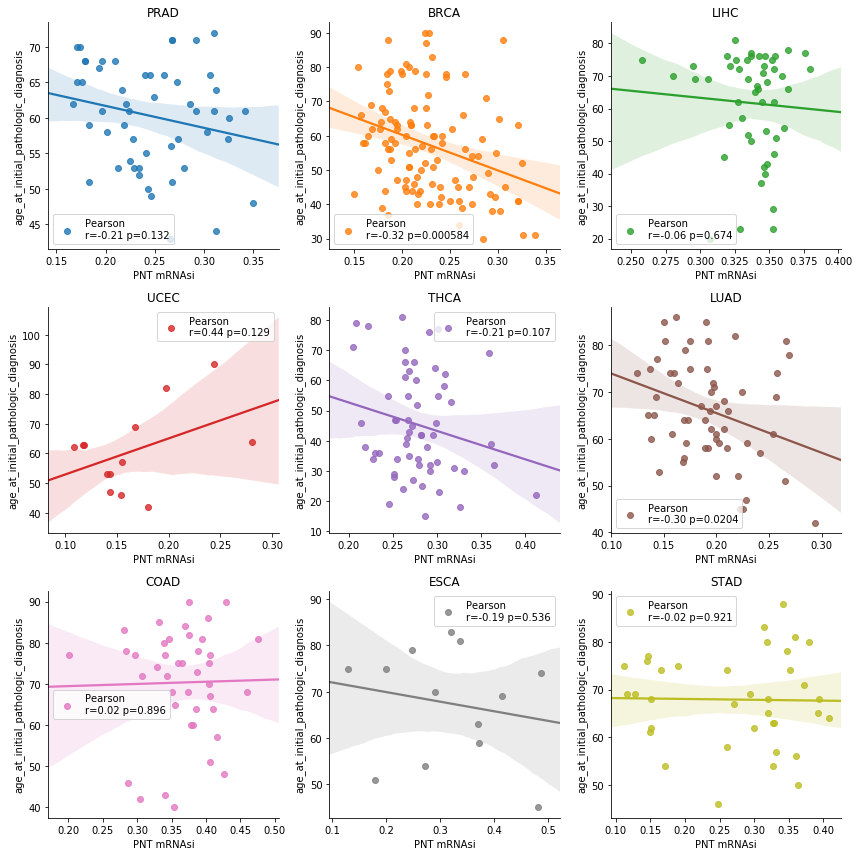

In [204]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
disease_list = ['PRAD', 'BRCA', 'LIHC', 'UCEC', 'THCA', 'LUAD', 'COAD', 'ESCA', 'STAD']
status= 'PNT'
# Drop [Not Available]
onset = tcga_info[tcga_info['age_at_initial_pathologic_diagnosis'] != '[Not Available]']['age_at_initial_pathologic_diagnosis']
onset = pd.to_numeric(onset)

for i in range(len(disease_list)):
    disease = disease_list[i]
    tmp_stem = stem[(stem['disease'] == disease) & (stem['tissue_status'] == status)].set_index('patient_id')
    

    
    idx = np.intersect1d(onset.index, tmp_stem.index)
    r, p = pearsonr(tmp_stem.loc[idx, 'mRNAsi'], onset[idx])
    sns.regplot(tmp_stem.loc[idx, 'mRNAsi'], onset[idx], ax=axes[i],
                label='Pearson \nr={0:.2f} p={1:.3}'.format(r, p))
    axes[i].set_xlabel('{0} mRNAsi'.format(status))
    axes[i].set_title(disease)
    axes[i].legend()
fig.tight_layout()
sns.despine()

In [205]:
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/All.PNT_mRNAsi_onset_age.png')
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/All.PNT_mRNAsi_onset_age.pdf')

(20, 100)

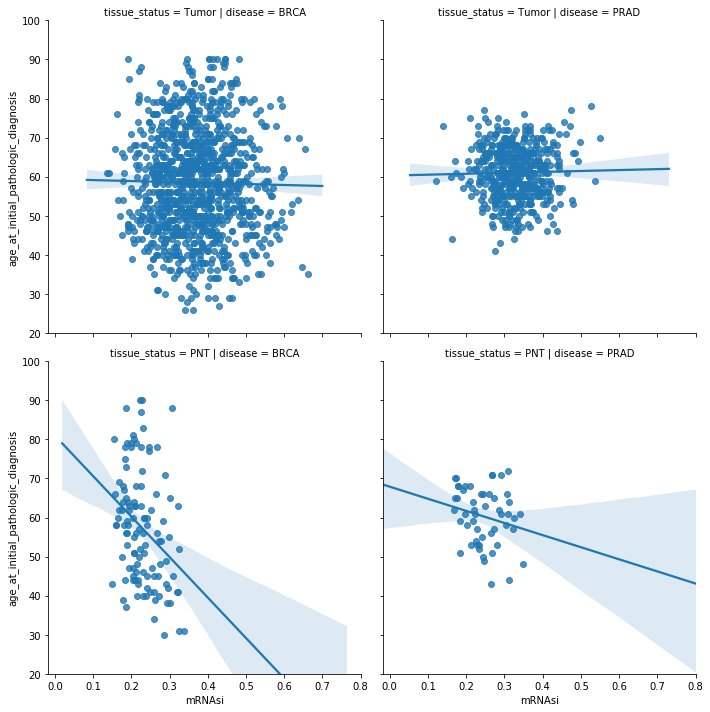

In [88]:
tmp_stem = stem[(stem['disease'] == 'BRCA') | (stem['disease'] == 'PRAD')].set_index('patient_id')
df = pd.concat([tmp_stem, pd.to_numeric(tcga_info.loc[tmp_stem.index, 'age_at_initial_pathologic_diagnosis'])], 
               axis=1, join='inner')

ax = sns.lmplot(x='mRNAsi', y='age_at_initial_pathologic_diagnosis', data=df, col='disease', row='tissue_status')
plt.ylim(20, 100)

In [90]:
ax.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.mRNAsi_onset_age.png')
ax.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.mRNAsi_onset_age.pdf')

In [119]:
brca_stem = stem[stem['disease'] == 'PRAD']
brca_stem = brca_stem[brca_stem.duplicated('patient_id', keep=False)]

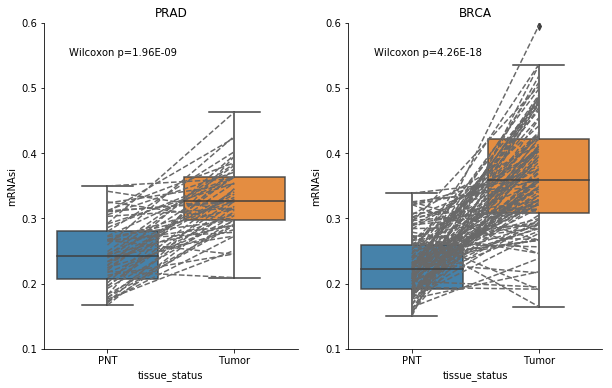

In [155]:
from scipy.stats import wilcoxon
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for i in range(2):
    diff = []
    brca_stem = stem[stem['disease'] == disease_list[i]]
    brca_stem = brca_stem[brca_stem.duplicated('patient_id', keep=False)]
    sns.boxplot(data=brca_stem, x='tissue_status', y='mRNAsi', order=['PNT', 'Tumor'], boxprops=dict(alpha=.9), ax=axes[i])
    for patient in brca_stem['patient_id'].unique():
        y1 = brca_stem[(brca_stem['patient_id'] == patient) & (brca_stem['tissue_status'] == 'PNT')]['mRNAsi'].values[0]
        y2 = brca_stem[(brca_stem['patient_id'] == patient) & (brca_stem['tissue_status'] == 'Tumor')]['mRNAsi'].values[0]
        diff.append(y2 -y1)
        axes[i].plot([0, 1], [y1, y2], ls='--', color='dimgrey')
    s, p = wilcoxon(diff)
    axes[i].text(-0.3, 0.55, 'Wilcoxon p={0:.2E}'.format(p))
    axes[i].set_title(disease_list[i])
    axes[i].set_ylim(0.1, 0.6)
sns.despine()

In [151]:
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.paired_mRNAsi.pdf')
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/PRAD_BRCA.paired_mRNAsi.png')

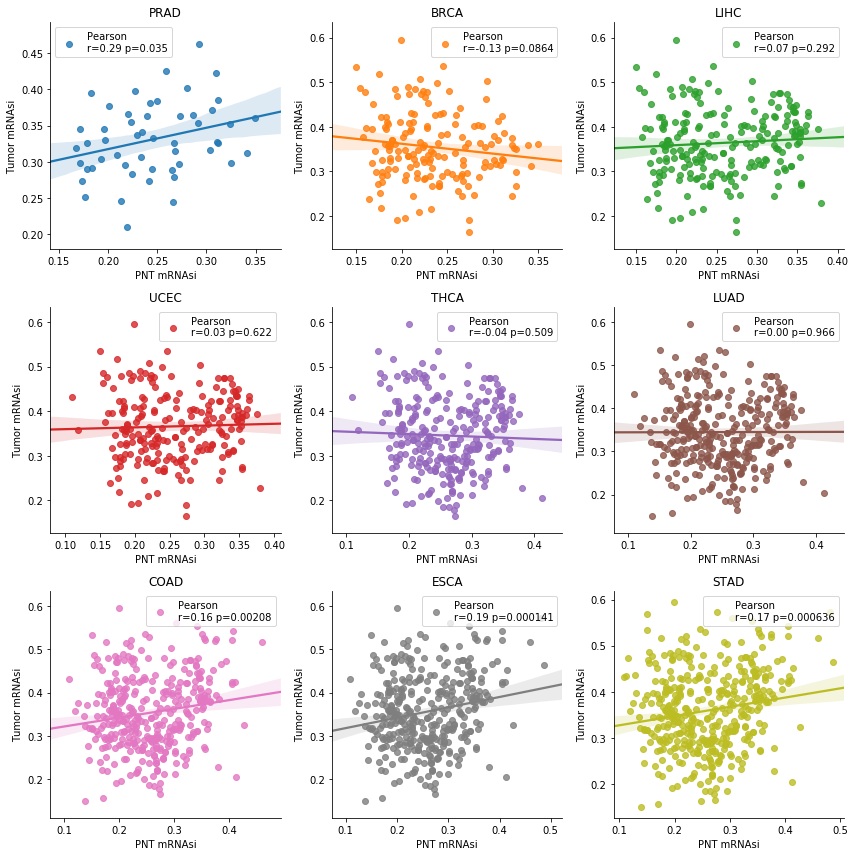

In [209]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
disease_list = ['PRAD', 'BRCA', 'LIHC', 'UCEC', 'THCA', 'LUAD', 'COAD', 'ESCA', 'STAD']
pnt_list = []
tumor_list = []
for i in range(len(disease_list)):
    brca_stem = stem[stem['disease'] == disease_list[i]]
    brca_stem = brca_stem[brca_stem.duplicated('patient_id', keep=False)]
    for patient in brca_stem['patient_id'].unique():
        y1 = brca_stem[(brca_stem['patient_id'] == patient) & (brca_stem['tissue_status'] == 'PNT')]['mRNAsi'].values[0]
        y2 = brca_stem[(brca_stem['patient_id'] == patient) & (brca_stem['tissue_status'] == 'Tumor')]['mRNAsi'].values[0]
        pnt_list.append(y1)
        tumor_list.append(y2)
    r, p = pearsonr(pnt_list, tumor_list)
    sns.regplot(pnt_list, tumor_list, ax=axes[i], 
                label='Pearson \nr={0:.2f} p={1:.3}'.format(r, p))
    axes[i].legend()
    axes[i].set_title(disease_list[i])
    axes[i].set_xlabel('PNT mRNAsi')
    axes[i].set_ylabel('Tumor mRNAsi')
fig.tight_layout()
sns.despine()

In [208]:
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/All.PNT_Tumor_mRNAsi_pearsonr.pdf')
fig.savefig('../data/TCGA-TARGET-GTEx/figures/20180921/All.PNT_Tumor_mRNAsi_pearsonr.png')